# **Spam Mail Detection using BERT Model**

## Installing Prerequisites for the BERT model

In [ ]:
!pip install tensorflow_text

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import tensorflow_text as text

Importing CSV

In [3]:
path = '/content/spam.csv'
df = pd.read_csv(path)

In [4]:
df.shape

(5572, 2)

In [5]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

## Handling Imbalanced Dataset

It's clearly an imbalanced dataset. We'll use the undersampling method to solve!

In [7]:
df_spam = df[df['Category']=='spam']
df_ham = df[df['Category']=='ham']

In [8]:
df_ham.shape

(4825, 2)

In [9]:
df_spam.shape

(747, 2)

We'll undersample the df_ham for having much more rows.

In [10]:
df_ham_undersampled = df_ham.sample(df_spam.shape[0])
df_ham_undersampled.shape

(747, 2)

In [11]:
df_balanced = pd.concat([df_ham_undersampled, df_spam])

In [12]:
df_balanced.shape

(1494, 2)

In [13]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [14]:
df_balanced.head()

,Category,Message
427,ham,aathi..where are you dear..
1235,ham,Hello-/@drivby-:0quit edrunk sorry iff pthis m...
3661,ham,I will reach ur home in &lt;#&gt; minutes
3017,ham,"&lt;#&gt; is fast approaching. So, Wish u a v..."
5276,ham,Dunno leh cant remember mayb lor. So wat time ...


Binary Classification

In [15]:
df_balanced['spam'] = df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)

In [16]:
df_balanced.sample(5)

,Category,Message,spam
3849,ham,Can you plz tell me the ans. BSLVYL sent via f...,0
1887,spam,Dear 0776xxxxxxx U've been invited to XCHAT. T...,1
5174,ham,Water logging in desert. Geoenvironmental impl...,0
4499,spam,Latest Nokia Mobile or iPOD MP3 Player +£400 p...,1
3893,spam,URGENT This is our 2nd attempt to contact U. Y...,1


Splitting dataset

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [18]:
X_train.head()

506     No it's waiting in e car dat's bored wat. Cos ...
4448    Please tell me you have some of that special s...
530                  Jay says that you're a double-faggot
1412    somewhere out there beneath the pale moon ligh...
1823        If you're thinking of lifting me one then no.
Name: Message, dtype: object

Importing BERT Model

In [19]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [20]:
def sentence_embedding(sentences):
  preprocessed_text = bert_preprocess(sentences)
  return bert_encoder(preprocessed_text)['pooled_output']

sentence_embedding(["Click here to claim your prize of $1,000,000!",
                    "Dear John, I hope you're doing well. Here's an update on our upcoming event.",
                    "Hi Jane, attached is the report you requested for last month's sales figures.",
                    "You've been selected to participate in a once-in-a-lifetime opportunity!"
                    ])

<tf.Tensor: shape=(4, 768), dtype=float32, numpy=
array([[-0.8528221 , -0.53160083, -0.94035506, ..., -0.7878836 ,
        -0.72182596,  0.8705099 ],
       [-0.91464466, -0.55315274, -0.9696954 , ..., -0.8824797 ,
        -0.7484891 ,  0.8763233 ],
       [-0.7978695 , -0.4418684 , -0.93546724, ..., -0.80444896,
        -0.6594817 ,  0.804064  ],
       [-0.8540286 , -0.46680662, -0.8814546 , ..., -0.68432236,
        -0.6956214 ,  0.8416538 ]], dtype=float32)>

Comparing among a few words using cosine similarity

In [25]:
comparing = sentence_embedding([
    "Mark Zuckerberg",
    "Shakib Al Hasan",
    "Marcus Rashford",
    "Lionel Messi",
    "Capsicum",
    "Banana"
])

In [22]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([comparing[0]],[comparing[1]])

array([[0.95798814]], dtype=float32)

In [23]:
cosine_similarity([comparing[2]],[comparing[3]])

array([[0.8714865]], dtype=float32)

Look! both index values are persons,

the similarity value tells the same!

In [27]:
cosine_similarity([comparing[3]],[comparing[5]])

array([[0.7670692]], dtype=float32)

Dissimilarity is clear here!

## Building Model

Here, we'll use Functional model instead of Sequential model.

In [28]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
result = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
result = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(result)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [result])

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_word_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

In [30]:
len(X_train)

1120

In [31]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

## Training the Model

In [32]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 26s 379ms/step - loss: 0.5987 - accuracy: 0.7161 - precision: 0.7010 - recall: 0.7536
Epoch 2/10
35/35 [==============================] - 14s 399ms/step - loss: 0.4831 - accuracy: 0.8304 - precision: 0.8094 - recall: 0.8643
Epoch 3/10
35/35 [==============================] - 13s 382ms/step - loss: 0.4323 - accuracy: 0.8536 - precision: 0.8438 - recall: 0.8679
Epoch 4/10
35/35 [==============================] - 12s 330ms/step - loss: 0.3924 - accuracy: 0.8580 - precision: 0.8427 - recall: 0.8804
Epoch 5/10
35/35 [==============================] - 12s 338ms/step - loss: 0.3568 - accuracy: 0.8786 - precision: 0.8533 - recall: 0.9143
Epoch 6/10
35/35 [==============================] - 12s 345ms/step - loss: 0.3318 - accuracy: 0.8857 - precision: 0.8857 - recall: 0.8857
Epoch 7/10
35/35 [==============================] - 12s 341ms/step - loss: 0.3145 - accuracy: 0.8964 - precision: 0.8841 - recall: 0.9125
Epoch 8/10
35/35 [================

In [33]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 6s 340ms/step - loss: 0.2399 - accuracy: 0.9171 - precision: 0.9483 - recall: 0.8824


[0.23987315595149994,
 0.9171122908592224,
 0.9482758641242981,
 0.8823529481887817]

In [34]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 4s 319ms/step


In [35]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,

## Confusion Matrix

In [36]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[178,   9],
       [ 22, 165]])

Text(50.722222222222214, 0.5, 'Truth')

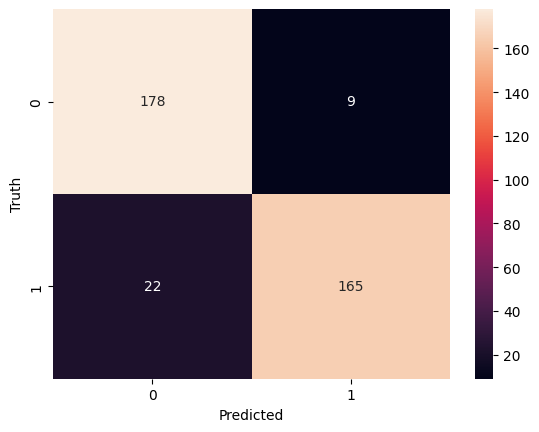

In [37]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [38]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       187
           1       0.95      0.88      0.91       187

    accuracy                           0.92       374
   macro avg       0.92      0.92      0.92       374
weighted avg       0.92      0.92      0.92       374



In [42]:
reviews = [
"You've been selected to participate in a once-in-a-lifetime opportunity!",
"URGENT: Your account will be suspended unless you verify your information!",
"Welcome to our online community! Start exploring our website today.",
"You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99",
"A special discount for our loyal customers: 20% off your next purchase.",
"Exclusive offer for a free iPhone - act now!"
]
model.predict(reviews)

1/1 [==============================] - 0s 50ms/step


array([[0.25271675],
       [0.58895487],
       [0.39092264],
       [0.7723062 ],
       [0.7722382 ],
       [0.869242  ]], dtype=float32)

## Remark:
Now, you can clearly see how perfectly this bert model can detect any emails. More than 0.5 is considered as spam mails indeed!